In [1]:
%matplotlib inline

# Введение в глубокое обучение с Keras и TensorFlow

**Ноутбук основан на работе Дениэла Мозера (Daniel Moser) из UT Southwestern Medical Center**

**Дополнительные источники: [Xavier Snelgrove](https://github.com/wxs/keras-mnist-tutorial), [Yash Katariya](https://github.com/yashk2810/MNIST-Keras)**

Чтобы помочь вам понять основы глубокого обучения, в этом ноутбуке будут рассмотрены основные этапы создания двух простых моделей для классификации рукописных цифр с точностью, превышающей 95%. Первая модель будет представлять собой базовую полносвязную нейронную сеть, а вторая модель будет более глубокой сетью с использованием концепций свертки и объединения.

## Задача для искусственного интеллекта (ИИ)

Наша цель — построить и обучить искусственную нейронную сеть на тысячах изображений рукописных цифр, чтобы она могла их успешно идентифицировать. Данные, которые будут использованы, представляют собой базу данных MNIST, которая содержит 60 000 изображений рукописных цифр для обучения и 10 000 тестовых изображений. Мы будем использовать API Keras Python с TensorFlow в качестве бэкэнда. *API - от англ. application programming interface — описание способов взаимодействия одной компьютерной программы с другими.*

В**от очень подробная русскоязычная статья на эту же тему: "Распознавание цифр для максимально маленьких"** https://habr.com/ru/articles/705306/, можете читать ее параллельно с выполнением упражнения.

**В книге Тарика Рашида** тоже есть тема классификации рукописных цифр (начиная со стр. 176) - можно параллельно подсматривать туда.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Небходимые модули Python

Во-первых, необходимо загрузить некоторое программное обеспечение (библиотеки) в среду Python.

In [2]:
import numpy as np                   # расширенная математическая библиотека
import matplotlib.pyplot as plt      # библиотека для построения графиков
import random                        # библиотека для генерации случайных чисел

from keras.datasets import mnist     # Набор данных MNIST включен в Keras
from keras.models import Sequential  # Тип модели нейронной сети, которая будет использоваться

from keras.layers import Dense, Dropout, Activation # Типы слоев, которые будут использоваться в нашей модели
from keras.utils import to_categorical  # некоторые дополнительные инструменты

## Загрузка исходных данных для обучения нейросети

Набор данных MNIST удобно встроен в Keras и мы можем легко проанализировать с помощью Python некоторые его свойства.

In [ ]:
# Данные MNIST разделены на 60 000 обучающих изображений размером 28x28 пикселей и 10 000 тестовых изображений размером 28x28 пикселей.
# Загружаем данные для обучения в переменные X_train и y_train, а тестовые данные в X_test, y_test
# В переменных X_train и X_test содержатся именно изображения цифр, а в переменных y_train и y_test содержатся соответствующие этим изображениям цифры - 0,1,2,3 и т.д.
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

Используя библиотеку matplotlib, мы можем вывести несколько образцов изображений из обучающего набора прямо в наш ноутбук:

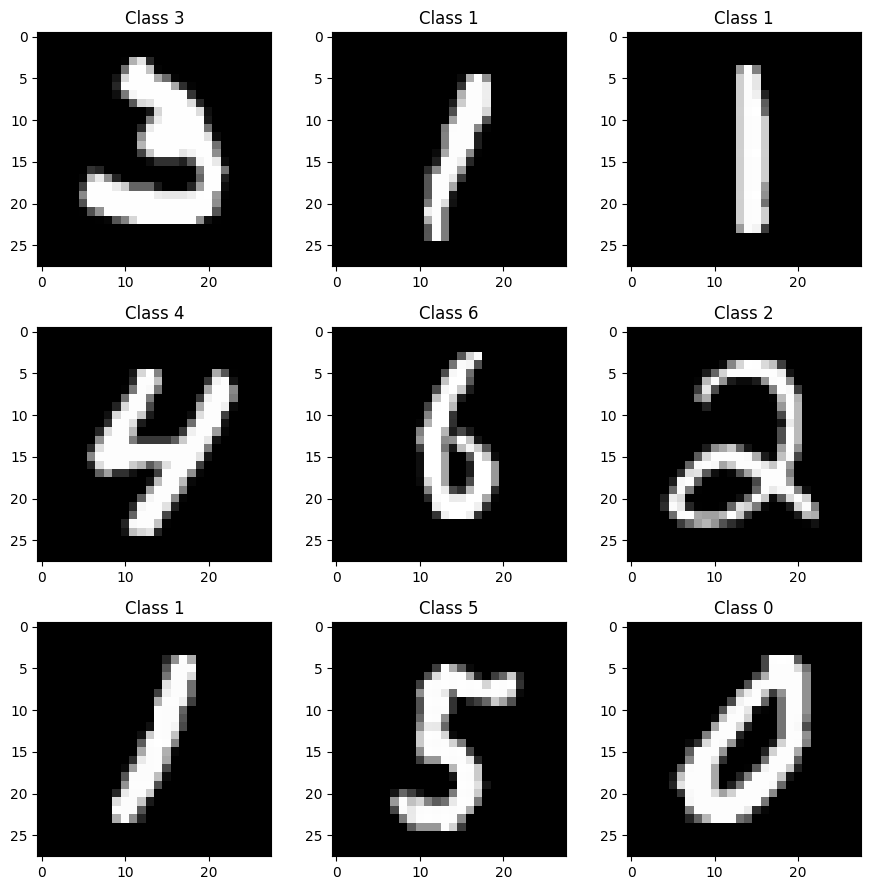

In [4]:
plt.rcParams['figure.figsize'] = (9,9) # Сделаем фигурки немного крупнее

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

Давайте рассмотрим какую-нибудь одну из цифр немного ближе и распечатаем массив, представляющий ее. В данном случае это цифра 6. Числа, из которых она состоит представляют собой градации серого от 0 (полностью черный цвет) до 255 (полностью белый цвет). Т.е. каждый пиксель представляет собой 8-битное целое число от 0 до 255. Это то, что мы называем одноканальным (монохромным) пикселем.

Забавный факт! Экран вашего компьютера имеет три канала для каждого пикселя: красный, зеленый и синий. Каждый из этих каналов также, вероятно, принимает 8-битное целое число. 3 канала — всего 24 бита — 16 777 216 возможных цветов!

In [6]:
# просто небольшая функция для красивой печати матрицы
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

matprint(X_train[num-2])

0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0   0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    7  171  255  156   58   0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    5   47   89  204  253  253  253  165   9  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0  113  253  253  253  253  253  253  190  19  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0  131  251  253  253  181  120  253  253  145   0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    

## Форматирование слоя входных данных

Вместо матрицы 28x28 пикселей мы строим нашу сеть так, чтобы она принимала на вход вектор длиной 784 пикселя. Т.е. наш входной слой будет иметь 784 нейрона (28х28 пикселей)

Таким образом каждое изображение необходимо преобразовать (или сгладить) в вектор. Мы также нормализуем входные данные так, чтобы они находились в диапазоне [0-1], а не [0-255]. Обычно рекомендуется нормализовать входные данные, чтобы любые дополнительные измерения (для других нейросетевых архитектур) имели один и тот же масштаб (подробнее можно почитать здесь: https://wiki.loginom.ru/articles/data-normalization.html)

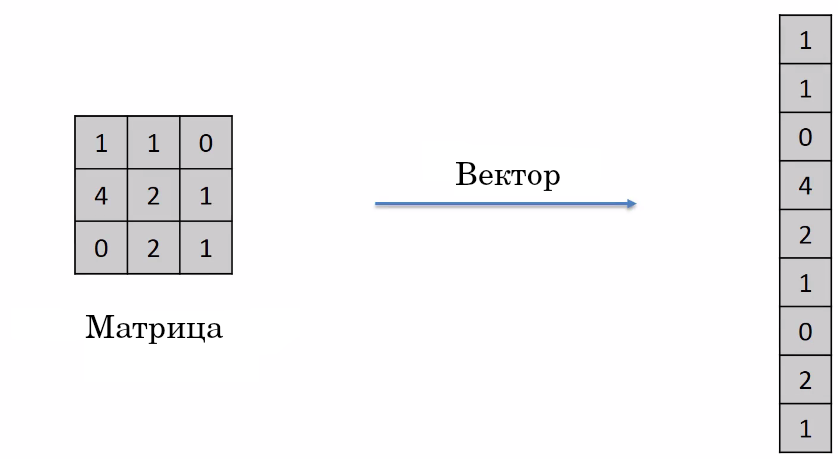

In [ ]:
X_train = X_train.reshape(60000, 784) # преобразовываем 60000 матриц обучающих изображений размером 28x28 в 60000 векторов длиной 784.
X_test = X_test.reshape(10000, 784)   # преобразовываем 10000 матриц тестовых изображений размером 28x28 в 10000 векторов длиной 784.

X_train = X_train.astype('float32')   # преобразуем целые числа в 32-битные числа с плавающей точкой
X_test = X_test.astype('float32')

X_train /= 255                        # нормализуем каждое значение для каждого пикселя
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Затем мы модифицируем наши уникальные цифры, чтобы они были в формате one-hot, т.е.

```
0 преобразуется в вектор [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 преобразуется в вектор [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 преобразуется в вектор [0, 0, 1, 0, 0, 0, 0, 0, 0]
и так далее до 9
```
Подробнее про one-hot encoding можно почитать здесь: https://pythonpip.ru/osnovy/one-hot-encoding-python

Например: если предсказание нашей сети будет очень близко к одному из этих векторов (классов), то, скорее всего, это именно этот вектор (класс), соответстуюющий определенной цифре. Если предсказание нейросети получилось таким:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
тогда наиболее вероятно, что это изображение цифры `1`, для которой выше мы ввели вектор: `[0, 1, 0, 0, 0, 0, 0, 0, 0]` (т.к. 0.94 очень близко к 1).

Слово "классы" у нас появилось не случайно, т.к. задача, которую мы решаем - это именно задача классификации, т.е. у нас есть десять классов (десять цифр: 0, 1, 2, ... 9) и входные изображения мы проверяем на принадлежность к одному из этих классов.

In [8]:
nb_classes = 10 # количество уникальных цифр

# здесь мы преобразуем наши "правильные ответы" (обучающие и тестовые) в one-hot вектора
# "правильные ответы" (Y_train и Y_test) - это у нас например массив вида: 7, 6, 0, 3, 3, 0, 1..., где каждая цифра соответствует изображению этой цифры 28х28 пикселей
# цифры из этих двух массивов мы преобразовываем в в one-hot вектора, для 0 - это [1, 0, 0, 0, 0, 0, 0, 0, 0] и так далее.
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Пишем 3-х слойную полносвязную нейронную сеть (fully connected network - FCN)

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

In [9]:
# Последовательная (Sequential) модель очень распространена, она представляет собой линейный набор слоев.

model = Sequential()

## Первый скрытый слой

In [10]:
# Первый скрытый слой представляет собой набор из 512 нейронов.
# Каждый такой нейрон получит значение из входного вектора и применит к этому входному значению некоторый вес и смещение.

model.add(Dense(512, input_shape=(784,))) #(784,) это не опечатка — это вектор длиной 784!

In [11]:
# «Активация» — это нелинейная функция, применяемая к выходным данным слоя.
# Она проверяет новое значение нейрона и решает, был ли превышен некий порог активации нейрона..
# Rectified Linear Unit (relu, см. ниже) — это наиболее часто используемая функция активации при глубоком обучении.
# Данная функция возвращает 0, если принимает отрицательный аргумент, в случае же положительного аргумента, функция возвращает само число.
# То есть она может быть записана как f(z)=max(0,z)
# Если relu возвращает 0, то эти нейроны не считаются активированными.
# Положительные значения на выходе нейронов после relu не изменяются.

model.add(Activation('relu'))

$$f(x) = max (0,x)$$
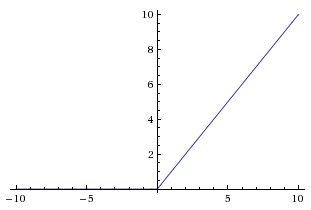

In [12]:
# Dropout обнуляет выбранные случайные выходы (т.е. отключает их активацию)
# Dropout помогает защитить модель от «переобучения» и запоминания обучающих данных.
model.add(Dropout(0.2)) # 0.2 означает, что будут обнулено 20% случайных выходов (т.е. 20% случайных нейронов не будут активированы, даже если до Dropout они уже были активированы)

## Добавляем второй скрытый слой.

In [13]:
# Второй скрытый слой выглядит идентично нашему первому слою.
# Однако вместо того, чтобы каждый из 512 нейронов получал 784 входных данных из входного изображения,
# они получают 512 входных данных с выхода первого слоя из 512 нейронов.

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))

## The Final Output Layer

In [14]:
# Последний слой из 10 нейронов полностью связан с предыдущим слоем из 512 нейронов (полносвязный слой).
# Количество нейронов в последнем слое полносвязной сети должно быть равно количеству желаемых классов (в данном случае 10).
model.add(Dense(10))

In [15]:
# Активация «softmax» представляет собой распределение вероятностей по K различным возможным результатам.
# У softmax все значения неотрицательны и в сумме равны 1.
# Про softmax подробнее можно почитать например здесь: https://yandex.ru/q/datascience/8263112449/

model.add(Activation('softmax'))

In [ ]:
# Подведем итог построенной модели

model.summary()

## Компиляция (сборка) модели

Keras (который мы используем) - это открытая библиотека, написанная на языке Python и обеспечивающая взаимодействие с искусственными нейронными сетями. Keras построен на основе библиотек Theano и TensorFlow. Обе библиотеки позволяют нам определить **график вычислений** в Python, который затем компилируется и эффективно работает на процессоре или графическом процессоре без накладных расходов интерпретатора Python (написано сложно, но ничего страшного - это просто дополнительная информация:)

При компиляции модели Keras просит вас указать **функцию потерь** и **оптимизатор**. Функция потерь, которую мы здесь будем использовать, называется *категориальной кросс-энтропией* и представляет собой функцию потерь, хорошо подходящую для сравнения двух распределений вероятностей. Просто об этом не расскажешь, предлагаю принять как данность:)

Наши прогнозы представляют собой распределения вероятностей по десяти различным цифрам (например, «мы на 80% уверены, что это изображение — 3, на 10% уверены, что это 8, на 5% — это 2 и т. д.»), а целью является распределение вероятностей.

Оптимизатор помогает определить, насколько быстро модель обучается посредством **градиентного спуска**. Скорость снижения градиента называется **скоростью обучения**.


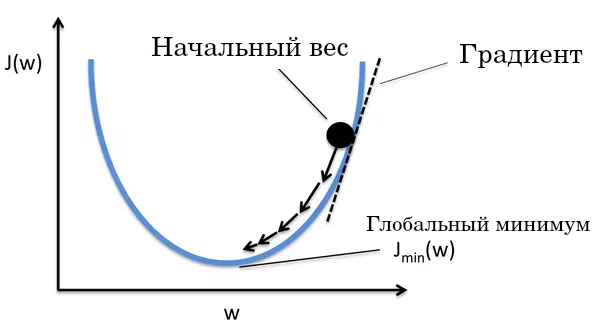

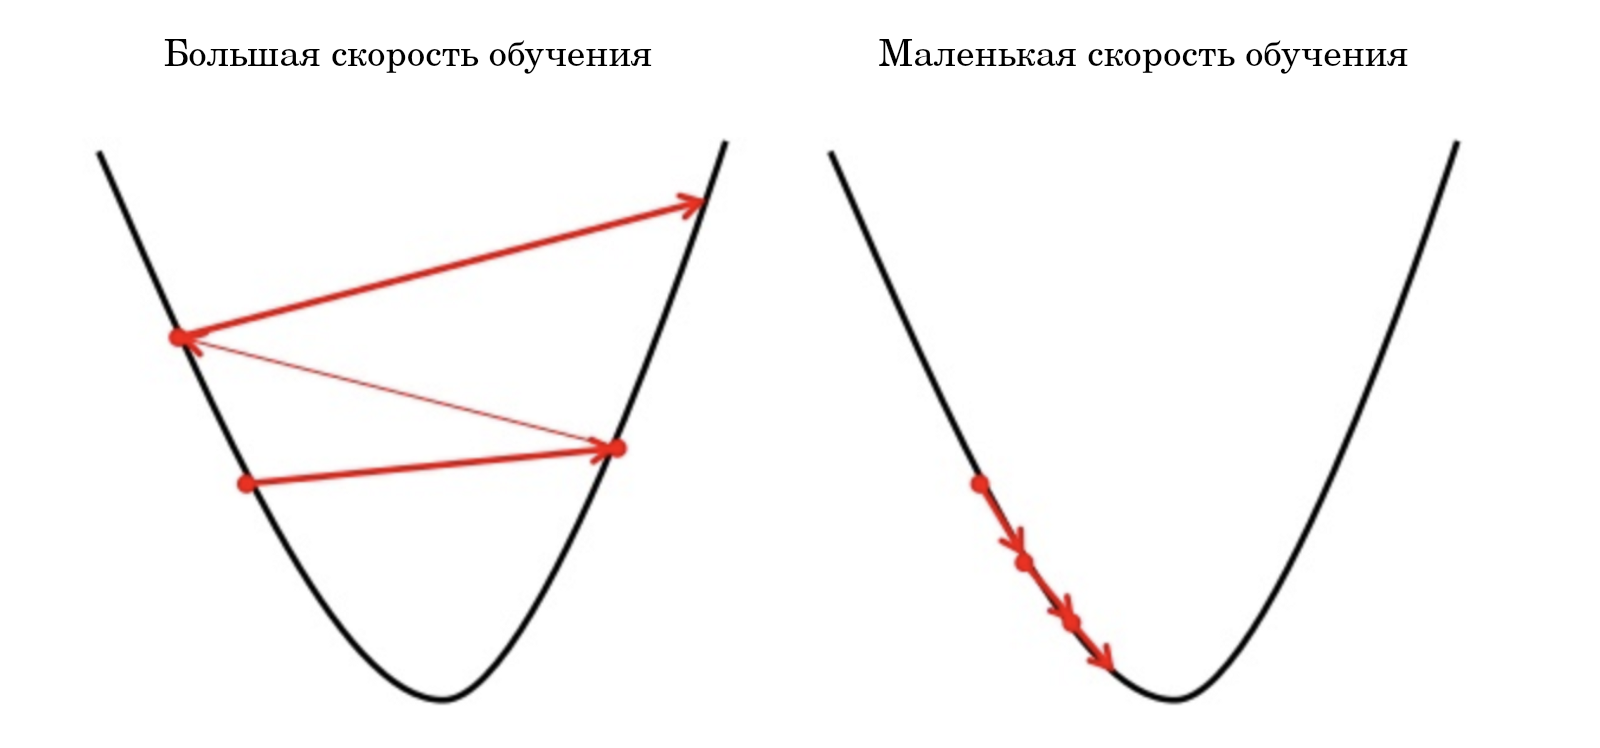

Так лучше ли меньшая скорость обучения? Не совсем! Для оптимизатора важно не застрять в локальных минимумах, пренебрегая глобальным минимумом функции потерь. Иногда это означает попытку увеличить скорость обучения, чтобы выйти за пределы локального минимума.Слишком маленькая скорость обучения заставляет алгоритм сходиться очень долго и застревать в локальных минимумах, слишком большая — «пролетать» узкие глобальные минимумы или вовсе расходиться, т.е. сеть не будет обучаться. **В книге Тарика Рашида это есть**.

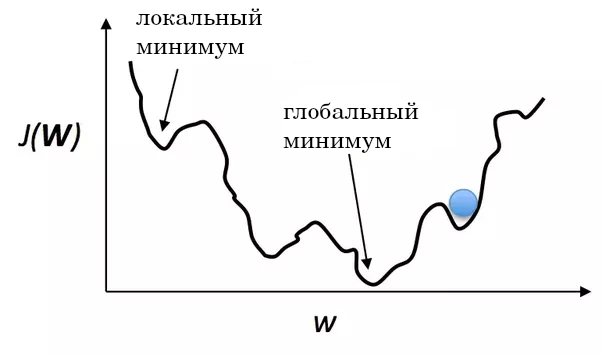

In [17]:
# Для обучения мы будем использовать оптимизатор 'adam', подробнее про оптимизаторы можно прочитать здесь: https://dzen.ru/a/ZCbHkmzpbAqLVmFA
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Теперь обучим нашу модель!
Это самая интересная часть))

Размер пакета (датасаентисты говорят "размер батча") определяет, сколько данных за шаг используется для вычисления функции потерь, градиентов и обратного распространения. Большие размеры батчей позволяют сети быстрее завершить обучение; однако есть и другие факторы, помимо скорости обучения, которые следует учитывать.

Слишком большой размер батча сглаживает локальные минимумы функции потерь, в результате чего оптимизатор останавливается на каком-то локальном минимуме, поскольку считает, что нашел глобальный минимум.

Слишком маленький размер батча создает очень шумную функцию потерь, и оптимизатор может никогда не найти глобальный минимум.

Таким образом, чтобы найти хороший размер батча, может потребоваться метод проб и ошибок!

In [ ]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=5,
          verbose=1)

Два числа (loss и accuracy) представляют значение функции потерь сети на обучающем наборе и общую точность сети на обучающих данных. Теперь посмотрим, как наша сеть справляется с данными, которых она раньше не видела и, соответственно, на них не обучалась? Речь идет про наши тестовые данные.

## Оценим точность модели на тестовых данных

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### Проверка результатов

Всегда полезно проверить выходные данные и убедиться, что всё нормально. Здесь мы рассмотрим несколько примеров, когда на выходе все хорошо, и несколько примеров, когда не очень хорошо.

In [ ]:
# Функция model.predict выводит класс с наибольшей вероятностью
# в соответствии с обученным классификатором для каждого входного примера.
predict_x=model.predict(X_test)
predicted_classes=np.argmax(predict_x,axis=1)

# Проверим, что мы получили правильно/неправильно
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

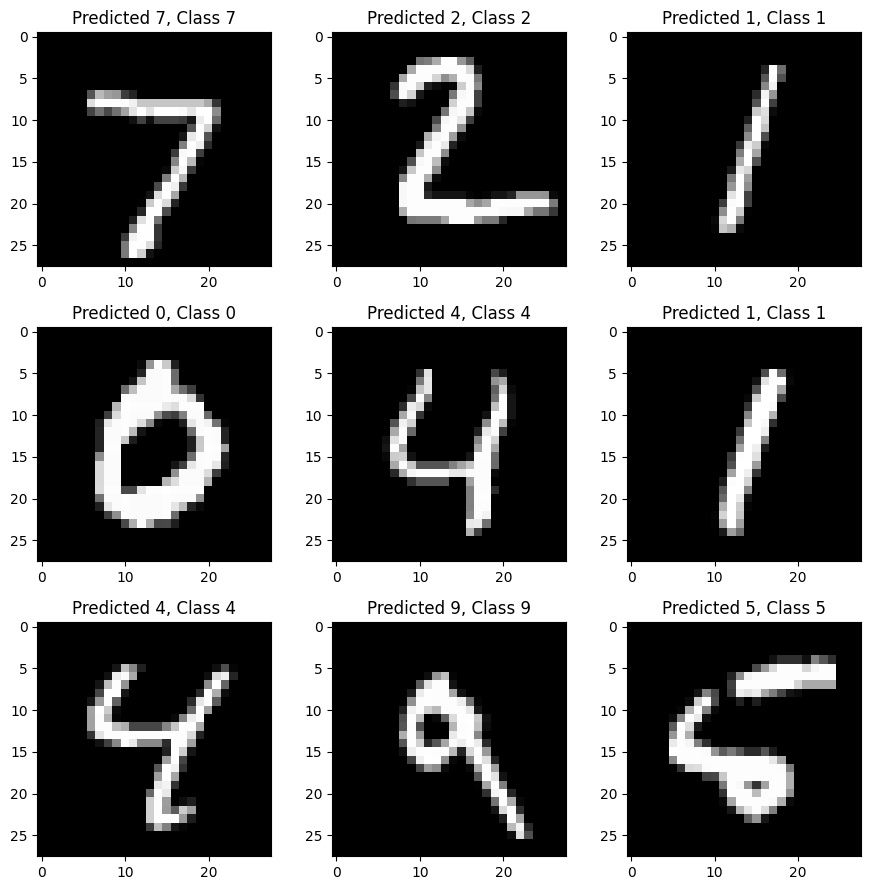

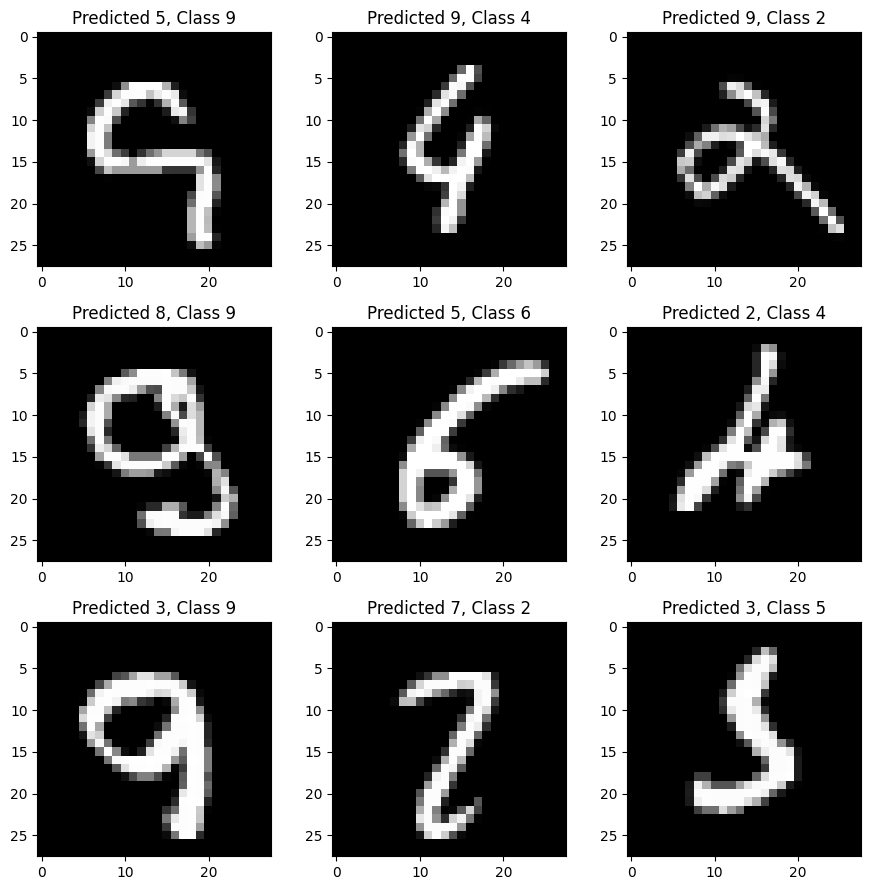

In [21]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.tight_layout()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

plt.tight_layout()

# Попробуйте поэкспериментировать с размером батча!

#### Как увеличение размера батча до 10 000 влияет на время обучения и точность тестирования?

#### Как насчет размера батча = 32?

# Представляем операцию свёртки! Что это такое?

Ранее мы построили сеть, которая принимает нормализованные значения пикселей каждого значения и работает только с этими значениями. Что, если бы вместо этого мы могли передать в сеть различные характеристики каждого изображения и заставить сеть узнать, какие характеристики важны для классификации изображения?

Это возможно благодаря свёртке! Свёртка применяет ядра (фильтры), которые проходят через каждое изображение и генерируют карты объектов.
Подробнее о свёртке можно почитать здесь: https://www.reg.ru/blog/svyortka-v-deep-learning-prostymi-slovami/

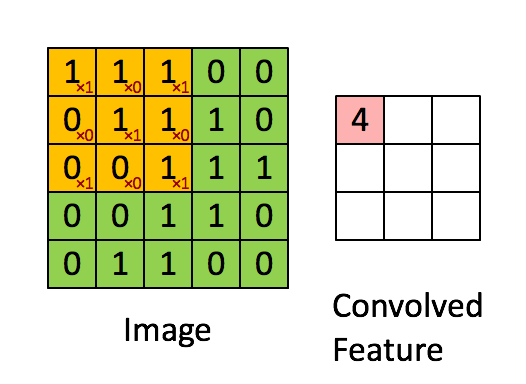

В приведенном выше примере изображение представляет собой матрицу 5 x 5, а ядро, обрабатывающее его, представляет собой матрицу 3 x 3. Между изображением и ядром происходит операция скалярного произведения и генерируется свернутый признак. Каждое ядро свёртки изучает разные характеристики изображения.

Ядра часто используются в программах для редактирования фотографий для применения размытия, обнаружения краев, повышения резкости и т.д.

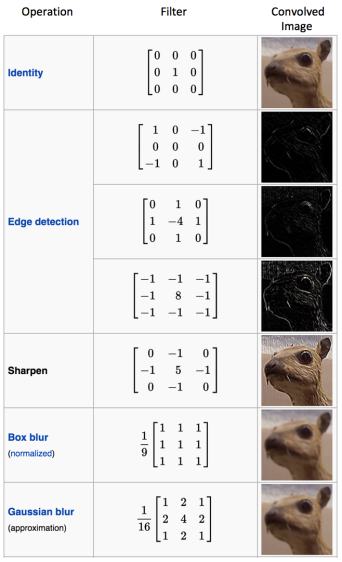

Ядра в сетях глубокого обучения используются аналогичным образом, то есть выделяют какую-то особенность. В сочетании с операцией, называемой maxpool, невыделенные элементы отбрасываются из каждой карты объектов, оставляя только интересующие объекты, уменьшая количество изученных параметров и уменьшая вычислительные затраты (например, системную память).

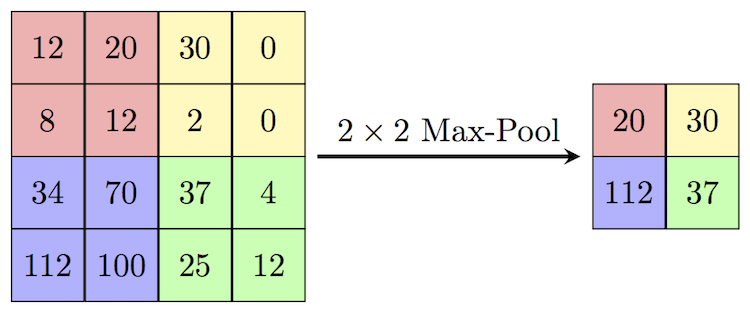

Мы также можем использовать свёртки из свёрток — мы можем складывать столько свёрток, сколько захотим, при условии, что пикселей будет достаточно, чтобы уместиться в ядро.

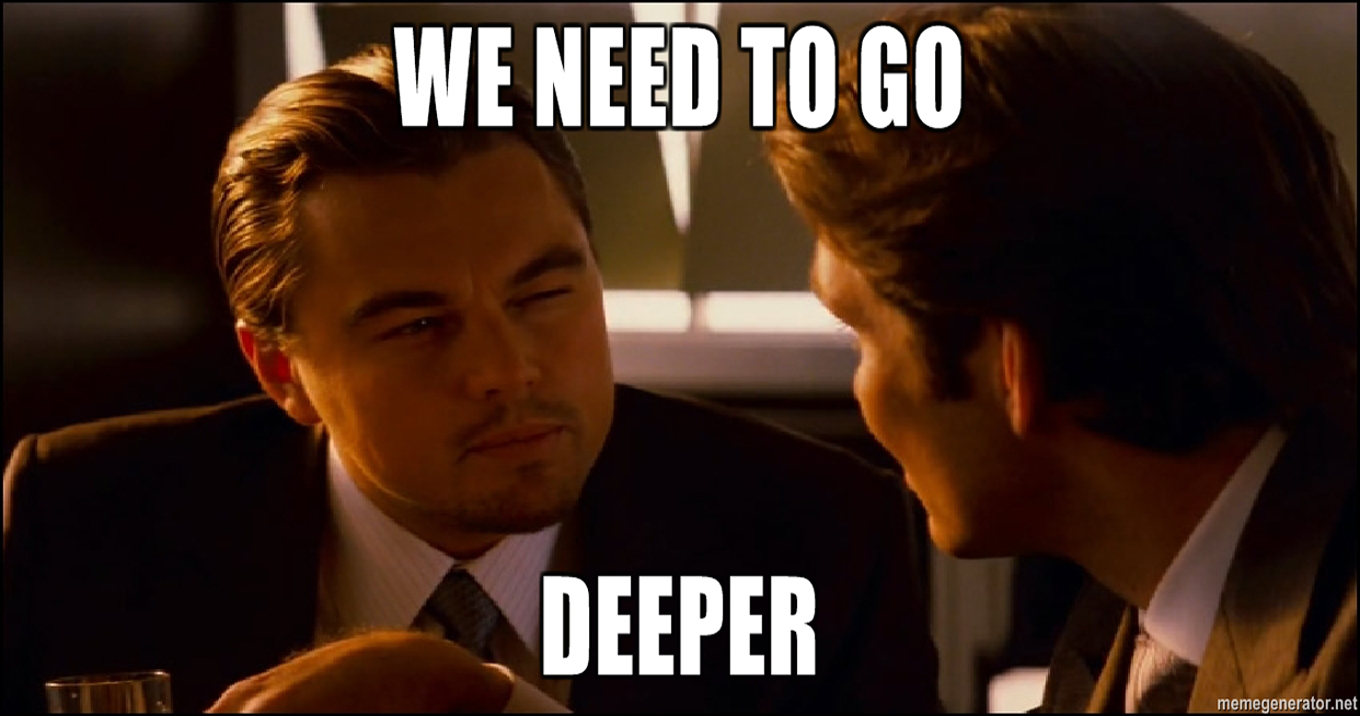

## Построение «глубокой» сверточной нейронной сети
Тема достатчно сложная, предарительно нужно что-нибудь почитать.
Например это: https://practicum.yandex.ru/blog/svertochnye-neyronnye-seti/
Или это: https://neurohive.io/ru/osnovy-data-science/glubokaya-svertochnaja-nejronnaja-set/, или снова это: https://www.reg.ru/blog/svyortka-v-deep-learning-prostymi-slovami/

In [24]:
# импортируем некоторые дополнительные инструменты

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers import BatchNormalization

In [25]:
# Еще раз загружаем набор данных MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [26]:
# Снова выполняем некое форматирование
# Правда теперь мы не преобразуем каждое изображение в вектор длиной 784, потому что мы хотим сначала выполнить свёртки.

X_train = X_train.reshape(60000, 28, 28, 1) # добавить дополнительное измерение для представления одноканального (монохромного) изображения
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # реобразуем целые числа в 32-битные числа с плавающей точкой
X_test = X_test.astype('float32')

X_train /= 255                              # нормализуем каждое значение для каждого пикселя
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [28]:
# снова выполняем one-hot преобразование

nb_classes = 10 # количество уникальных цифр (и, соответственно, количество уникальных классов)

Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

In [29]:
model = Sequential()                                 # Модель та же, что и в случае с полносвязной сетью
                                                     # вся разница в слоях
# Сверточный слой №1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 различных ядра 3x3 — то есть 32 карты признаков.
model.add(BatchNormalization(axis=-1))               # нормализуем каждую карту признаков перед активацией
convLayer01 = Activation('relu')                     # активация
model.add(convLayer01)

# Сверточный слой №2
model.add(Conv2D(32, (3, 3)))                        # 32 различных ядра 3x3 — то есть 32 карты признаков.s
model.add(BatchNormalization(axis=-1))               # нормализуем каждую карту признаков перед активацией
model.add(Activation('relu'))                        # активация
convLayer02 = MaxPooling2D(pool_size=(2,2))          # применяем MaxPooling* (cм. комментарий в самом низу)
model.add(convLayer02)

# Сверточный слой №3
model.add(Conv2D(64,(3, 3)))                         # 64 различных ядра 3x3 — то есть 64 карты признаков.
model.add(BatchNormalization(axis=-1))               # нормализуем каждую карту признаков перед активацией
convLayer03 = Activation('relu')                     # активация
model.add(convLayer03)

# Сверточный слой №4
model.add(Conv2D(64, (3, 3)))                        # 64 различных ядра 3x3 — то есть 64 карты признаков.
model.add(BatchNormalization(axis=-1))               # нормализуем каждую карту признаков перед активацией
model.add(Activation('relu'))                        # активация
convLayer04 = MaxPooling2D(pool_size=(2,2))          # пуллинг максимальных значений
model.add(convLayer04)
model.add(Flatten())                                 # преобразуем окончательную выходную матрицу 4x4x64 в вектор длиной 1024.

# Полносвязный слой №5
model.add(Dense(512))                                # 512 полносвязных нейронов
model.add(BatchNormalization())                      # нормализация
model.add(Activation('relu'))                        # активация

# Полносвязный слой №6
model.add(Dropout(0.2))                              # dropout (отсев) 20% случайно выбранных нейронов
model.add(Dense(10))                                 # 10 полносвязных выходных нейронов (выходной слой)
model.add(Activation('softmax'))                     # активация softmax

# *Подобно сверточному слою, пулинговый слой необходим для уменьшения размера свернутого элемента в пространстве.
# Это помогает уменьшить вычислительную мощность, необходимую для обработки данных, за счет уменьшения размерности.
# Кроме того, это важно и для извлечения доминирующих признаков, инвариантных вращения и позиционирования, таким образом поддерживая процесс эффективного обучения модели.
# Существует два типа пулинга: максимальный (Max Pooling) и средний (Average Pooling).
# Максимальный пулинг возвращает максимальное значение из части изображения, покрываемой ядром свертки.

In [ ]:
model.summary()

In [31]:
# используем тот же оптимизатор 'adam'

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [32]:
# аугментация данных предотвращает переобучение путем небольшого случайного изменения данных
# В Keras имеется отличная встроенную функция для автоматической аугментации.
# Про аугментацию можно почитать здесь: https://neerc.ifmo.ru/wiki/index.php?title=Практики_реализации_нейронных_сетей (первые несколько абзацев)

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [33]:
# Как и до этого, мы можем передавать наши дополненные (аугментированные) данные батчами.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [ ]:
# Теперь мы можем обучать нашу модель, которая получает данные от нашего пакетного загрузчика train_generator.
# Количество шагов за эпоху всегда должно быть равно общему размеру набора, деленному на размер батча.

model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,
                    validation_data=test_generator, validation_steps=10000//128)

In [ ]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

## Прекрасные результаты!